In [15]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import r2_score

In [3]:
files = glob.glob("../results/tclr_model/all/TD*_exhaustive/results.pickle")

In [9]:
def find_depth(file):
    mat = re.search(r"TD(.*)_RT_MS", file)
    return mat.groups(1)[0]

In [10]:
data = {}
for file in files:
    d = find_depth(file)
    results = pd.read_pickle(file)["simmed_data"]
    data[d] = results

In [12]:
def calc_binned_score(df):
    df["pct"] = df.groupby("site_name")["actual"].rank(pct=True)
    def make_bin(x):
        if x <= 1/3:
            return 1
        elif x <= 2/3:
            return 2
        else:
            return 3
    df["bin"] = df["pct"].apply(make_bin)
    scores = df.groupby(["site_name", "bin"]).apply(lambda x: r2_score(x["actual"], x["model"]))
    return scores

In [19]:
binned_scores = {i: calc_binned_score(j) for i,j in data.items()}

In [21]:
binned_metrics = {i: {"mean":j.groupby("bin").mean(), "median":j.groupby("bin").median(), "std":j.groupby("bin").std()} for i, j in binned_scores.items()}

In [26]:
bmedians = pd.DataFrame({i: j["median"] for i, j in binned_metrics.items()})
bmeans = pd.DataFrame({i: j["mean"] for i, j in binned_metrics.items()})
bstds = pd.DataFrame({i: j["std"] for i, j in binned_metrics.items()})

In [33]:
bstds.T.sort_values(by=[1, 2, 3]).mean(axis=1).sort_values()

7     6.927116e+02
6     7.958739e+02
4     1.148355e+03
5     1.353148e+03
3     1.702923e+03
2     1.710745e+03
1     3.264597e+03
8     4.749573e+04
9     1.928140e+05
10    1.851979e+06
dtype: float64

In [37]:
bs_df = []
for key, df in binned_scores.items():
    df = pd.DataFrame({"NSE":df})
    df["depth"] = int(key)
    bs_df.append(df)
bs_df = pd.concat(bs_df).reset_index()

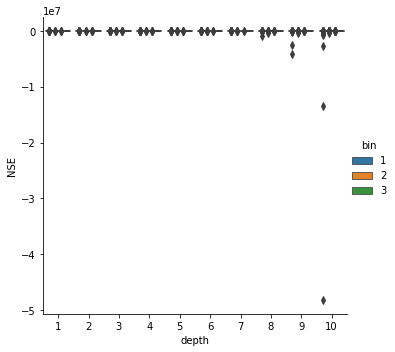

In [40]:
sns.catplot(data=bs_df, x="depth", y="NSE", hue="bin", kind="box")
plt.show()